In [1]:
import pandas as pd
import numpy as np
import time

from sklearn import preprocessing

from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


from sklearn.cluster import KMeans

from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn import preprocessing

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve

In [2]:
dfAdult = pd.read_csv(".\\data\\adult.csv")

result_dict = {}
np.random.seed =10

# reshuffle input data ..good thing for neural netwrok
#dfAdult = dfAdult.sample(frac=1).reset_index(drop=True) 
dfAdultWithoutSalary = dfAdult.drop(columns=['salary'])
dfAdultHotEncoded = pd.get_dummies(dfAdult,columns=['salary','education','workclass','occupation','relationship','marital-status','race','sex'])
dfAdultHotEncoded = dfAdultHotEncoded.drop(columns=['salary_ <=50K','native-country'])
X_HotEncoded = dfAdultHotEncoded.drop('salary_ >50K',axis=1)
Y_HotEncoded = dfAdultHotEncoded['salary_ >50K']

X_HotEncoded_NumOfFeatures = len(list(X_HotEncoded.columns))

label_encoding = preprocessing.LabelEncoder()
dfAdult['salary'] = label_encoding.fit_transform(dfAdult['salary'])
dfAdult['education'] = label_encoding.fit_transform(dfAdult['education'])
dfAdult['workclass'] = label_encoding.fit_transform(dfAdult['workclass'])
dfAdult['occupation'] = label_encoding.fit_transform(dfAdult['occupation'])
dfAdult['relationship'] = label_encoding.fit_transform(dfAdult['relationship'])
dfAdult['marital-status'] = label_encoding.fit_transform(dfAdult['marital-status'])
dfAdult['race'] = label_encoding.fit_transform(dfAdult['race'])
dfAdult['sex'] = label_encoding.fit_transform(dfAdult['sex'])
dfAdult['native-country']=label_encoding.fit_transform(dfAdult['native-country'])

X = dfAdult.drop('salary',axis=1)
Y = dfAdult['salary']
X_LabelEncoded_NumOfFeatures = len(list(X.columns))
print(X.columns)
print(X.shape)



print(X_HotEncoded.columns)
print(X_HotEncoded.shape)
#X=X_HotEncoded
#Y=Y_HotEncoded
#X = X[:, None]


Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
(32561, 14)
Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'education_ 10th', 'education_ 11th',
       'education_ 12th', 'education_ 1st-4th', 'education_ 5th-6th',
       'education_ 7th-8th', 'education_ 9th', 'education_ Assoc-acdm',
       'education_ Assoc-voc', 'education_ Bachelors', 'education_ Doctorate',
       'education_ HS-grad', 'education_ Masters', 'education_ Preschool',
       'education_ Prof-school', 'education_ Some-college', 'workclass_ ?',
       'workclass_ Federal-gov', 'workclass_ Local-gov',
       'workclass_ Never-worked', 'workclass_ Private',
       'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc',
       'workclass_ State-gov', 'workclass_ Without-pay', 'occupatio

In [18]:
def GMM_Model(data,i):
            cv_type = "full"
            gmm = GaussianMixture(n_components=i,
                                          covariance_type=cv_type,random_state=10,max_iter=1000)
            cluster_labels = gmm.fit_predict(data)
            data_new = data.copy()
            data_new["ClusterLabel"] =  cluster_labels
            return data_new,cluster_labels
            

In [19]:
def kMeans_Model(data,i):
        km = KMeans(
            n_clusters=i, init='random',
            n_init=10, max_iter=1000,
            tol=1e-04, random_state=0
        )
        
        cluster_labels = km.fit_predict(data)
        data_new = data.copy()
        data_new["ClusterLabel"] =  cluster_labels
        return data_new,cluster_labels

In [12]:
def summarise_classification(Y_test,Y_pred):
    
    acc = accuracy_score(Y_test,Y_pred,normalize=True)
    prec = precision_score(Y_test,Y_pred)
    rec = recall_score(Y_test,Y_pred)
    roc = roc_auc_score(Y_test,Y_pred)
    r2 = r2_score(Y_test,Y_pred)
    mse = mean_squared_error(Y_test,Y_pred)
    acc_count = accuracy_score(Y_test,Y_pred,normalize=False)
    model_crosstab = pd.crosstab(Y_test,Y_pred)
    return {'accuracy':acc,'precision':prec,'recall':rec ,'AUC':roc,'accuracy_count':acc_count,'r2Score':r2,'mean_squared_error':mse,'confusionmatrix':model_crosstab}


In [14]:
def buildModel(class_fn,X,Y,test_frac=0.2):
        
    X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size=test_frac)
    model = class_fn(X_train,Y_train)
    
    Y_pred = model.predict(X_test)
    
    Y_pred_train = model.predict(X_train)
    train_summary = summarise_classification(Y_train,Y_pred_train)
    test_summary = summarise_classification( Y_test,Y_pred)
    
    pred_result = pd.DataFrame({'Y_test':Y_test,'Y_pred':Y_pred})    
    
    
    return model,{'training':train_summary,'test':test_summary}

In [13]:
def compare_results(key1):
    for key in result_dict:
        if(key==key1):
            print ('Classification: ',key)
            print()
            print('Training data')
            for scorekey in result_dict[key]['training']:
                print(scorekey,': ',result_dict[key]['training'][scorekey])

            print()
            print('Test data')
            for scorekey in result_dict[key]['test']:
                print(scorekey, ': ' ,result_dict[key]['test'][scorekey])
        
        print()   

In [15]:
def classifier_fn(x_train,y_train):
    model = MLPClassifier(hidden_layer_sizes =5,max_iter=60000)   
    start_time = time.time()
    model.fit(x_train,y_train)
    print("training time base model: ",(time.time() - start_time) ," seconds")
    
    return model

In [16]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores= \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    #fit_times_mean = np.mean(fit_times, axis=1)
    #fit_times_std = np.std(fit_times, axis=1)
  
    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")
    """
    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")
    """
    return plt

In [10]:
#ADULT Original_NN
#COPy from other experiment

training time base model:  499.871212720871  seconds
Classification:  MLPClassifier_Adult_GMM

Training data
accuracy :  0.8490863022113022
precision :  0.7209695603156708
recall :  0.610695527614197
AUC :  0.767781358545272
accuracy_count :  22117
r2Score :  0.17545654517132092
mean_squared_error :  0.1509136977886978
confusionmatrix :  col_0             0     1
salary_ >50K             
0             18280  1485
1              2446  3837

Test data
accuracy :  0.8403193612774451
precision :  0.6944444444444444
recall :  0.5937098844672657
AUC :  0.7557853155938751
accuracy_count :  5473
r2Score :  0.1225885342925872
mean_squared_error :  0.1596806387225549
confusionmatrix :  col_0            0    1
salary_ >50K           
0             4548  407
1              633  925



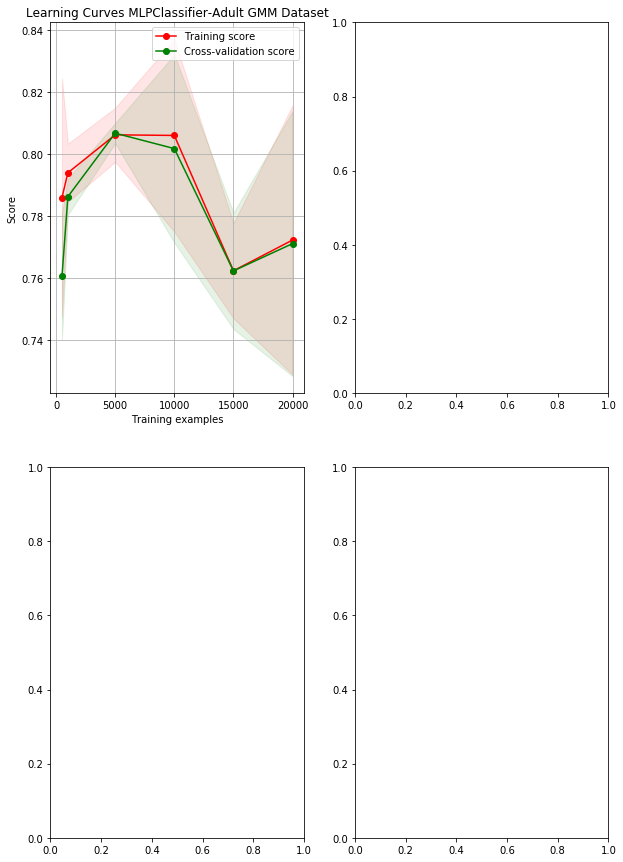

In [17]:
#ADULT GMM
data_new = GMM_Model(X_HotEncoded,2)
key1="MLPClassifier_Adult_GMM"
model,result_dict[key1] = buildModel(classifier_fn,data_new,Y_HotEncoded)
compare_results(key1)

train_sizes = [500,1000,5000, 10000, 15000, 20000]
fig, axes = plt.subplots(2, 2, figsize=(10, 15))

#X, y = load_digits(return_X_y=True)

title = "Learning Curves MLPClassifier-Adult GMM Dataset"

plot_learning_curve(model, title, data_new, Y_HotEncoded, axes=axes[:, 0],
                    cv=3, n_jobs=-1,train_sizes=train_sizes)

plt.show()

training time base model:  2.6231067180633545  seconds

Classification:  MLPClassifier_Adult_ICA

Training data
accuracy :  0.7644732800982801
precision :  0.9929078014184397
recall :  0.02231431303793433
AUC :  0.5111318707902325
accuracy_count :  19913
r2Score :  -0.2881009664871319
mean_squared_error :  0.2355267199017199
confusionmatrix :  col_0             0    1
salary_ >50K            
0             19773    1
1              6134  140

Test data
accuracy :  0.7630892062029787
precision :  1.0
recall :  0.015315890236119975
AUC :  0.50765794511806
accuracy_count :  4970
r2Score :  -0.2966533778593108
mean_squared_error :  0.23691079379702135
confusionmatrix :  col_0            0   1
salary_ >50K          
0             4946   0
1             1543  24



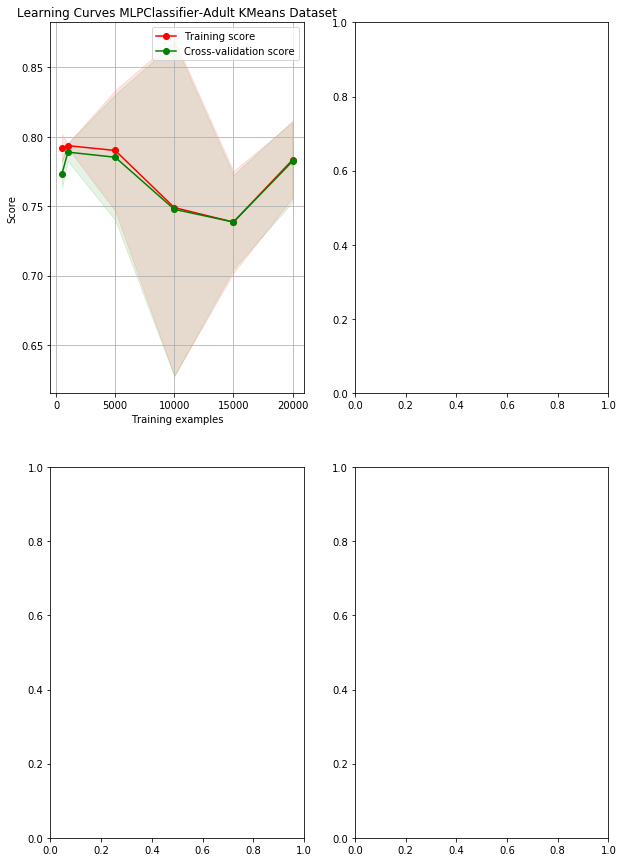

In [18]:
#ADULT Kmeans_NN
data_new = kMeans_Model(X_HotEncoded,2)
key1="MLPClassifier_Adult_ICA"
model,result_dict[key1] = buildModel(classifier_fn,data_new,Y_HotEncoded)
compare_results(key1)

train_sizes = [500,1000,5000, 10000, 15000, 20000]
fig, axes = plt.subplots(2, 2, figsize=(10, 15))

#X, y = load_digits(return_X_y=True)

title = "Learning Curves MLPClassifier-Adult KMeans Dataset"

plot_learning_curve(model, title, data_new, Y_HotEncoded, axes=axes[:, 0],
                    cv=3, n_jobs=-1,train_sizes=train_sizes)

plt.show()

training time base model:  0.45105743408203125  seconds
Classification:  MLPClassifier_Adult_GMM

Training data
accuracy :  0.7580236486486487
precision :  0.0
recall :  0.0
AUC :  0.5
accuracy_count :  19745
r2Score :  -0.3192200557103062
mean_squared_error :  0.24197635135135134
confusionmatrix :  col_0             0
salary_ >50K       
0             19745
1              6303

Test data
accuracy :  0.7638569015814525
precision :  0.0
recall :  0.0
AUC :  0.5
accuracy_count :  4975
r2Score :  -0.3091457286432162
mean_squared_error :  0.23614309841854753
confusionmatrix :  col_0            0
salary_ >50K      
0             4975
1             1538



C:\Users\vparihar\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vparihar\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


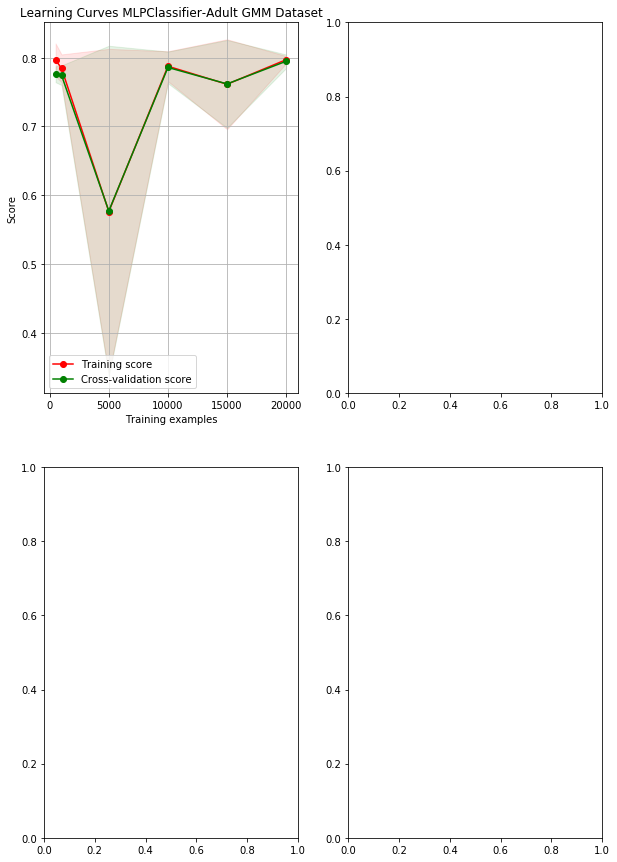

In [21]:
#ADULT GMM
data_new,cluster_labels = GMM_Model(X_HotEncoded,2)
key1="MLPClassifier_Adult_GMM"
model,result_dict[key1] = buildModel(classifier_fn,pd.DataFrame(cluster_labels),Y_HotEncoded)
compare_results(key1)

train_sizes = [500,1000,5000, 10000, 15000, 20000]
fig, axes = plt.subplots(2, 2, figsize=(10, 15))

#X, y = load_digits(return_X_y=True)

title = "Learning Curves MLPClassifier-Adult GMM Dataset"

plot_learning_curve(model, title, data_new, Y_HotEncoded, axes=axes[:, 0],
                    cv=3, n_jobs=-1,train_sizes=train_sizes)

plt.show()

training time base model:  1.4773595333099365  seconds

Classification:  MLPClassifier_Adult_ICA

Training data
accuracy :  0.7585227272727273
precision :  0.0
recall :  0.0
AUC :  0.5
accuracy_count :  19758
r2Score :  -0.31835205992509374
mean_squared_error :  0.24147727272727273
confusionmatrix :  col_0             0
salary_ >50K       
0             19758
1              6290

Test data
accuracy :  0.7618608935974206
precision :  0.0
recall :  0.0
AUC :  0.5
accuracy_count :  4962
r2Score :  -0.3125755743651759
mean_squared_error :  0.23813910640257946
confusionmatrix :  col_0            0
salary_ >50K      
0             4962
1             1551



C:\Users\vparihar\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vparihar\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


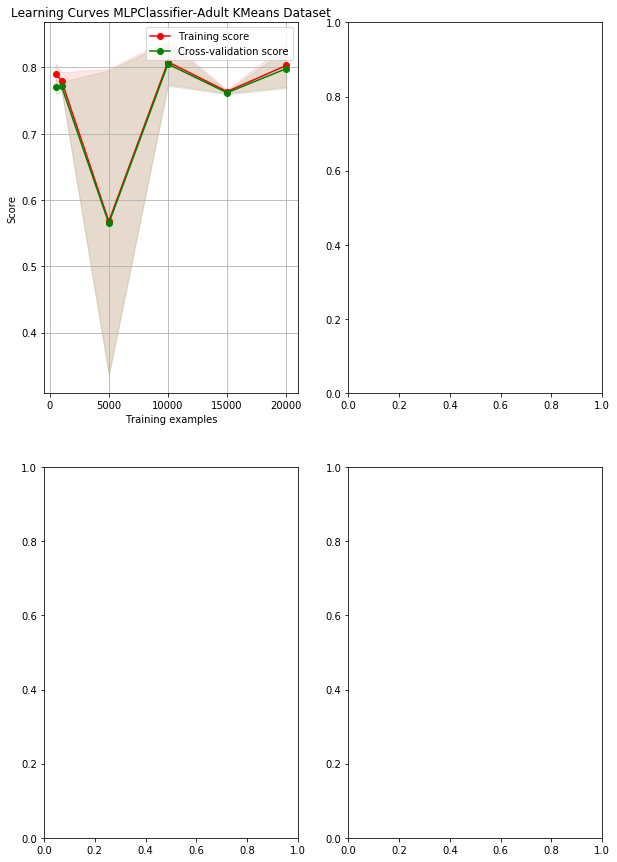

In [22]:
#ADULT Kmeans_NN
data_new,cluster_labels = kMeans_Model(X_HotEncoded,2)
key1="MLPClassifier_Adult_ICA"
model,result_dict[key1] = buildModel(classifier_fn,pd.DataFrame(cluster_labels),Y_HotEncoded)
compare_results(key1)

train_sizes = [500,1000,5000, 10000, 15000, 20000]
fig, axes = plt.subplots(2, 2, figsize=(10, 15))

#X, y = load_digits(return_X_y=True)

title = "Learning Curves MLPClassifier-Adult KMeans Dataset"

plot_learning_curve(model, title, data_new, Y_HotEncoded, axes=axes[:, 0],
                    cv=3, n_jobs=-1,train_sizes=train_sizes)

plt.show()